In this notebook, we go through methods distance metrics. The distance metrics is used at the following settings:
1. Defining objective function in decision tree learning
2. Defining loss function of classification problems
3. Evaluating the distance between two random variables
4. Comparing clusters
5. Feature selection

The detail of implementations will be found at finance_ml/distance.py.

In [1]:
# %matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Correlation Based Metrics

To define $d(X, Y)$ as a proper metric, it needs to satisfy the following properties:
1. identity of indiscernible: $d(X,Y) = 0 \Leftrightarrow X = Y$
2. symmetry: $d(X, Y) = d(Y, X)$
3. triangle inequality: $d(X, Y) \leq d(X, Z) + d(Z, Y)$
4. non negativity: $d(X, Y) \geq 0$

The correlation does not satisfy non-negativity and triangle inequality.
Instead, we can define : $d[X, Y] = \sqrt{1 / 2 (1 - \rho [X, Y])}$, which satisfy all of the above properties.
This metric is ranged [0, 1]. 

When you consider portfolio optimization, you would see that -1 correlation adds no diversification and prefer that absolute value of correlation close to 0. Then, you can use $d[X, Y] = \sqrt{1 - |\rho [X, Y]|}$ instead.

The metric is implemented as `corr_metric`.

# Entropy Based Metrics

The correlation has three caveats:
1. Quantifying only linear co-dependence
2. Being highly influenced by outliers
3. Beyond multivariate Normal case is questionable

To overcome this case, we introduce entropy based concepts

- $H[X] = - \sum_{x} p[x] log[p[x]]$
- $H[X, Y] = - \sum_{x, y} p[x, y] log[p[x, y]]$
- $H[X | Y] = - \sum_{y} p[y] \sum_{x} p[x | y] log[p[x | y]]$

H[X], entropy, quantifies how concentrated distribution is. Entropy is maximum at uniform distribution and minimum at constant value. That is, you may say it quantifies the uncertainty of the variable. H[X | Y] quantifies how the uncertainty exists after getting Y value on the average while H[X, Y] simply quantifies the joint entropy. If X and Y are independent to each other, $H[X | Y] = H[X]$ and $H[X, Y] = H[X] + H[Y]$.

We define the value quantifying the amount of sharing information, mutual information:
$$I[X, Y] = \sum_{x, y} p[x, y] log[\frac{p[x, y]}{p[x]p[y]}] = H[X] - H[X|Y]$$

From the first definition, mutual information quantifies how large the joint entropy is compared to the case where X and Y are independent. From the second definition, mutual information quantifies how much determining of Y reduces the uncertainty of X. Under the assumption that Y is a certain r.v., I[X, Y] is maximum at the case $X \equiv Y$, $I[X, Y] = H[Y]$ and minimum at the case where X is independent of Y, $I[X, Y] = 0$. 

By re-writing the equation,
$$H[X] = I[X, Y] + H[X|Y]$$

If you use an analogy that $H[X]$ and $H[Y]$ as the information on set $A$ and $B$, you may consider this as a set equation:
$$A = (A\cap B) \cup A\cap B^c$$

Thus, H[X], I[X, Y], and H[X|Y] can be seen as the information on set $A$, $A\cap B$, and $A\cap B^c$, respectively

Mutual information satisfies 1, 2, 4 of metric properties. Only triangle inequality is not satisfied.

To overcome this situation, we introduce variation of information:

$$VI[X, Y] = H[X | Y] + H[Y | X] = H[X] + H[Y] - 2 I[X, Y]$$
=>
$$VI[X, Y] + I[X, Y] = H[X] + H[Y] - I[X, Y]$$

VI[X, Y] quantifies the information, which is not shared across X and Y. If $X \equiv Y$, $VI[X, Y] = 0$. If X and Y are independent, $VI[X, Y] = H[X] + H[Y]$.
From the second equation, we can see $VI[X, Y]$ as information on $(A\cap B^c) \cup (B\cap A^c)$ from the previous analogy.

# Discretization

To estimate empirically distribution, you need to define discretization. Discretization is arbitrary and affects the quality of empirical distribution estimation. We use the method developed by [Hachine-Gharbi](https://www.sciencedirect.com/science/article/abs/pii/S0167865512000761) here.

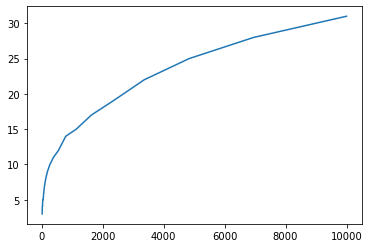

In [2]:
from finance_ml.distance import _num_bins

n_obs_list = [int(x) for x in np.logspace(1, 4, 20)]
bin_sizes = [_num_bins(x) for x in n_obs_list]
plt.plot(n_obs_list, bin_sizes)

Let's look at the relation between discrete and continuous entropy definition.
In the case of continuous, we can write down

$$H[X] = -\int f[x] log[f[x]] dx$$
where $f[x]$ is probability distribution function.

When discretizing, we define finite mass probability $P([x, x + \Delta x]) \approx f[x] \Delta x$.
Based on this, we define
$$\hat{H}[X] = -\sum_{x} f[x]\Delta x log[f[x] \Delta x] = - log[\Delta x] -\sum_{x} f[x]\Delta x log[f[x]]$$
Then, we have
$$H[X] \approx -\sum_{x} f[x] log[f[x]] \Delta x = log[\Delta x] + \hat{H}[X] $$

We can deduce back to integral based entropy.

Let's try on Gaussian distribution

In [3]:
gaussian_entropy = 0.5 * np.log(2 * np.pi * np.exp(1))
print(f"close formula standar normal distribution entropy is {gaussian_entropy}")

close formula standar normal distribution entropy is 1.4189385332046727


In [4]:
from finance_ml.distance import entropy

n_obs_list = [int(x) for x in np.logspace(2, 6, 50)]
errs1 = list()
errs2 = list()
errs = list()
for n_obs in n_obs_list:
    x = np.random.normal(0, 1, size=n_obs)
    bx1 = int(round(0.1 * n_obs))
    bx1 = max(bx1, 1)
    bx2= int(round(0.01 * n_obs))
    bx2 = max(bx2, 1)
    err = abs(gaussian_entropy - entropy(x, is_cont=True))
    err1 = abs(gaussian_entropy - entropy(x, bx1, is_cont=True))
    err2 = abs(gaussian_entropy - entropy(x, bx2, is_cont=True))
    errs.append(err)
    errs1.append(err1)
    errs2.append(err2)

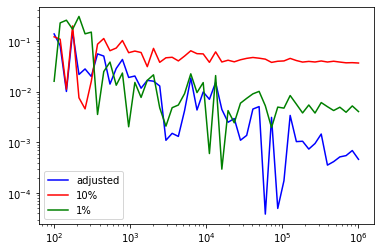

In [5]:
plt.plot(n_obs_list, errs, label='adjusted', color='b')
plt.plot(n_obs_list, errs1, label='10%', color='r')
plt.plot(n_obs_list, errs2, label='1%', color='g')
plt.plot()
plt.legend()
plt.xscale('log');
plt.yscale('log');

The graph compares our adjusted bin size to 10% and 1% of range bin size as to entropy estimation error.
The adjusted result performs well from small to large sample size range.

Next try out how information variables change as correlation changes.

In [6]:
from tqdm import tqdm_notebook

from finance_ml.distance import entropy, joint_entropy, cond_entropy, mutual_info, variation_info

rhos = np.linspace(-1, 1, 11)
size = 10000
hxs = list()
hys = list()
hxys = list()
hxy_conds = list()
ixys = list()
vxys = list()
vxy_norms = list()
for rho in tqdm_notebook(rhos):
    mu = [0, 0]
    cov = [[1, rho], [rho, 1]]
    xy = np.random.multivariate_normal(mu, cov, size=size)
    x = xy[:, 0]
    y = xy[:, 1]
    hxs.append(entropy(x))
    hys.append(entropy(y))
    hxys.append(joint_entropy(x, y))
    hxy_conds.append(cond_entropy(x, y))
    ixys.append(mutual_info(x, y))
    vxys.append(variation_info(x, y))
    vxy_norms.append(variation_info(x, y, True))

<ipython-input-6-d118f7c4a05f>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for rho in tqdm_notebook(rhos):


  0%|          | 0/11 [00:00<?, ?it/s]

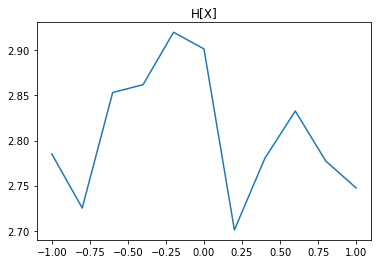

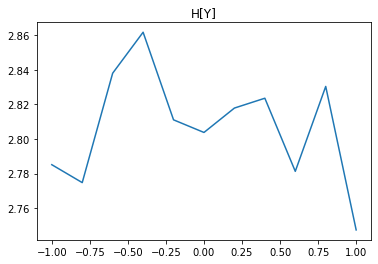

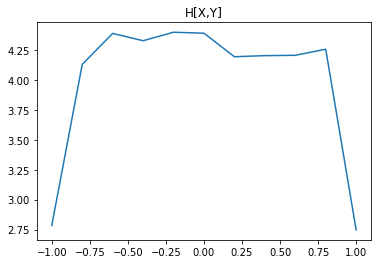

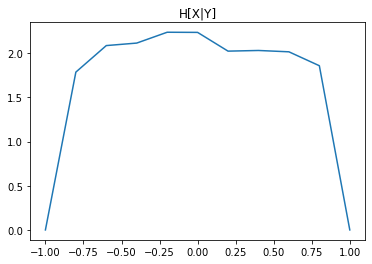

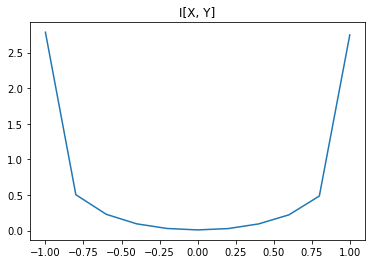

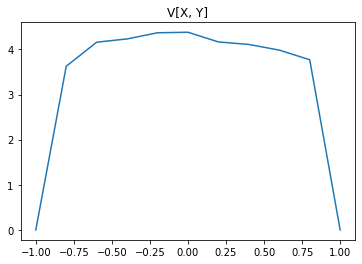

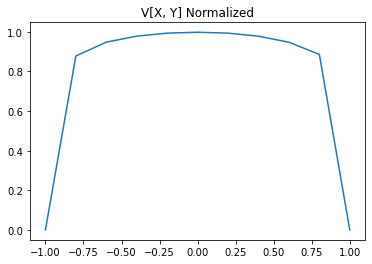

In [7]:
plt.figure()
plt.title("H[X]")
plt.plot(rhos, hxs);
plt.figure()
plt.title("H[Y]")
plt.plot(rhos, hys);
plt.figure()
plt.title("H[X,Y]")
plt.plot(rhos, hxys);
plt.figure()
plt.title("H[X|Y]")
plt.plot(rhos, hxy_conds);
plt.figure()
plt.title("I[X, Y]")
plt.plot(rhos, ixys);
plt.figure()
plt.title("V[X, Y]")
plt.plot(rhos, vxys);
plt.figure()
plt.title("V[X, Y] Normalized")
plt.plot(rhos, vxy_norms);

While each entropy is not affected by correlation value, other metrics changes as absolute value of correlation changes.

# Correlation vs Mutual Information

Mutual information is able to non-linear relation while correlation does not.

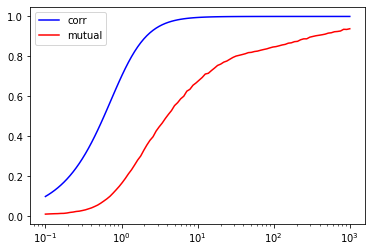

In [8]:
size = 5000
x = np.random.randn(size)
e = np.random.randn(size)

alphas = np.logspace(-1, 3, 100)

corrs = list()
mutus = list()

for alpha in alphas:
    y = alpha * x + e
    corrs.append(np.corrcoef(x, y)[0, 1])
    mutus.append(mutual_info(x, y, True))
    
plt.plot(alphas, corrs, color='b', label='corr');
plt.plot(alphas, mutus, color='r', label='mutual');
plt.legend();
plt.xscale('log');

In the linear case, $y = \alpha x + e$, value increases as signal gets stronger than noise $e$.

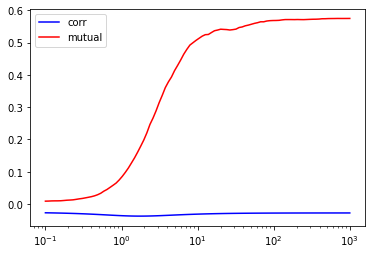

In [9]:
size = 5000
x = np.random.randn(size)
e = np.random.randn(size)

alphas = np.logspace(-1, 3, 100)

corrs = list()
mutus = list()

for alpha in alphas:
    y = alpha * np.abs(x) + e
    corrs.append(np.corrcoef(x, y)[0, 1])
    mutus.append(mutual_info(x, y, True))
    
plt.plot(alphas, corrs, color='b', label='corr');
plt.plot(alphas, mutus, color='r', label='mutual');
plt.legend();
plt.xscale('log');

In the non-linear case, $y = \alpha |x| + e$, correlation does not capture the relation anymore even if strong signal exists. Note that strong signal does not bring mutual information to 1 since x and y are not 1-to-1 mapping.